In [1]:
import numpy as np
import os
import json
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2

In [2]:
class Object3d(object):
    ''' 3d object label '''
    def __init__(self, obj):
        # extract label, truncation, occlusion
        self.type = obj["classname"]

        self.occlusion = obj["occlusion"] 
        self.quat = np.array(obj["orientation_quat"])
        self.rotationmatrix = self.get_rotationmatrix()
        
        # extract 3d bounding box information
        self.h = obj["dimension3d"][2] # box height
        self.w = obj["dimension3d"][1] # box width
        self.l = obj["dimension3d"][0] # box length (in meters)
        self.t = (obj["center3d"][0],obj["center3d"][1],obj["center3d"][2])
        
        self.distance = np.sqrt(np.sum(np.square(self.t))) 
        
        self.bbox = self.get_bbox()
        self.angle = self.get_angle()[2]
        if self.angle >=0:
            self.angle = self.angle * 180 / np.pi
        else:
            self.angle = self.angle * 180 / np.pi + 360

    def get_angle(self):
        w = self.quat[0]
        x = self.quat[1]
        y = self.quat[2]
        z = self.quat[3]
        return (math.atan2(2*(w*x+y*z),1-2*(x*x+y*y)), math.asin(2*(w*y-z*x)),
                math.atan2(2*(w*z+x*y),1-2*(y*y+z*z)))  


    def get_bbox(self):
        center = np.array(self.t)
        dimension = np.array([self.l, self.w, self.h])

        w = dimension[0] + 0.1
        l = dimension[1] + 0.1
        h = dimension[2] 

        x_corners = [-w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2]
        y_corners = [l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2]
        z_corners = [h / 2, h / 2, h / 2, -h / 2, -h / 2, -h / 2, -h / 2, h / 2]

        R = self.rotationmatrix
        bbox = np.vstack([x_corners, y_corners, z_corners])
        bbox = np.dot(R, bbox)
        bbox = bbox + center[:, np.newaxis]

        bbox = np.transpose(bbox)

        return bbox
    
    def get_rotationmatrix(self):
        n = np.dot(self.quat, self.quat)
        if n < np.finfo(self.quat.dtype).eps:
            rot_matrix = np.identity(4)
            return rot_matrix
        q = self.quat * np.sqrt(2.0 / n)
        q = np.outer(q, q)
        rot_matrix = np.array(
            [[1.0 - q[2, 2] - q[3, 3], q[1, 2] + q[3, 0], q[1, 3] - q[2, 0]],
             [q[1, 2] - q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] + q[1, 0]],
             [q[1, 3] + q[2, 0], q[2, 3] - q[1, 0], 1.0 - q[1, 1] - q[2, 2]]],
            dtype=q.dtype)
        rot_matrix = np.transpose(rot_matrix)
        return rot_matrix    
    
class calib_astyx():
    """Calibration class"""
    def __init__(self, file):
        with open(file) as json_file:
            data = json.load(json_file)
            
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])
        
        self.ref2radar = self.inv_trans(self.radar2ref)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])

    @staticmethod
    def inv_trans(T):
        rotation = np.linalg.inv(T[0:3, 0:3])
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))

        return Q
    
    def lidar2ref(self, points):
        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))
        
        return points_ref[:,0:3]

    def ref2Camera(self, points, img_size):
        obj_image = np.dot(self.ref2camera[0:3, 0:3], points.T)
        T = self.ref2camera[0:3, 3]
        obj_image = obj_image + T[:, np.newaxis]
        obj_image = np.dot(self.K, obj_image)
        obj_image = obj_image / obj_image[2]
        obj_image = np.delete(obj_image, 2, 0)
        mask = (obj_image[0,:] <= img_size[0]) & \
                (obj_image[1,:] <= img_size[1]) & \
                (obj_image[0,:] >= 0) & (obj_image[1,:] >= 0) & \
                (points[:,0] >= 0)
        return obj_image[:, mask]

In [3]:
def get_sub_points_of_object(obj, pc):
    pc_rot = np.dot(np.linalg.inv(obj.rotationmatrix), pc.T)
    corners =  np.dot(np.linalg.inv(obj.rotationmatrix), obj.bbox.T)

    x_max = corners[0].max()
    x_min = corners[0].min()
    y_max = corners[1].max()
    y_min = corners[1].min()
    z_max = corners[2].max()
    z_min = corners[2].min()
    
    mask = (pc_rot[0] < x_max) & (pc_rot[0] > x_min) & \
            (pc_rot[1] < y_max) & (pc_rot[1] > y_min) & \
            (pc_rot[2] < z_max) & (pc_rot[2] > z_min)
    
    return pc[mask]

In [4]:
idx = 60
object_number = 0
root_dir = "../../../../remote/astyx/dataset/dataset_astyx_hires2019/"

image_dir = os.path.join(root_dir, "camera_front")
calib_dir = os.path.join(root_dir, "calibration")
lidar_dir = os.path.join(root_dir, "lidar_vlp16")
objects_dir = os.path.join(root_dir, "groundtruth_obj3d")

img = cv2.imread(os.path.join(root_dir, "camera_front/%06d.jpg" % idx))
with open(os.path.join(objects_dir, "%06d.json" % idx), "r") as json_file:
    data = json.load(json_file)
objects = [Object3d(obj) for obj in data["objects"]]

assert len(objects) > object_number, \
    "Scene %06d has only %d objects. Python lists start at 0 and the last object has index len(list)-1." %(idx, len(objects))
assert objects[object_number].type == "Car", \
    "Object %d is not a car, but a %s." % (object_number, objects[object_number].type)

calib = calib_astyx(os.path.join(root_dir, "calibration/%06d.json" % idx))
lidar = np.loadtxt(os.path.join(root_dir, "lidar_vlp16/%06d.txt" % idx), skiprows=1)[:,0:3]
lidar = calib.lidar2ref(lidar)

object_points = get_sub_points_of_object(objects[object_number], lidar)

object_points_FOV = np.int32(calib.ref2Camera(object_points,[img.shape[1],img.shape[0]]))
lidar_FOV = np.int32(calib.ref2Camera(lidar,[img.shape[1],img.shape[0]]))

In [5]:
print("The object %d of type %s in scene %06d:" % (object_number, objects[object_number].type, idx))
print("Number of LiDAR Points: %d" % object_points_FOV.shape[1])
print("Distance to ego: %.2f m." % objects[object_number].distance)
print("Rotation of the %s: %.2f degree." % (objects[object_number].type, objects[object_number].angle))

In [13]:
data = [go.Scatter3d(x = lidar[:,0],
                     y = lidar[:,1],
                     z = lidar[:,2],
                    mode='markers', type='scatter3d',
                    marker={
                        'size': 1,
                        'color': "red",
                        'colorscale':'rainbow'
}),
       go.Scatter3d(x = object_points[:,0],
                     y = object_points[:,1],
                     z = object_points[:,2],
                    mode='markers', type='scatter3d',
                    marker={
                        'size': 1,
                        'color': "blue",
                        'colorscale':'rainbow'
})]
layout = go.Layout(
    scene={
        'xaxis': {'range': [-25, 25], 'rangemode': 'tozero', 'tick0': -5},
        'yaxis': {'range': [-25, 25], 'rangemode': 'tozero', 'tick0': -5},
        'zaxis': {'range': [-15, 15], 'rangemode': 'tozero'}
    }
)
go.Figure(data=data, layout=layout)

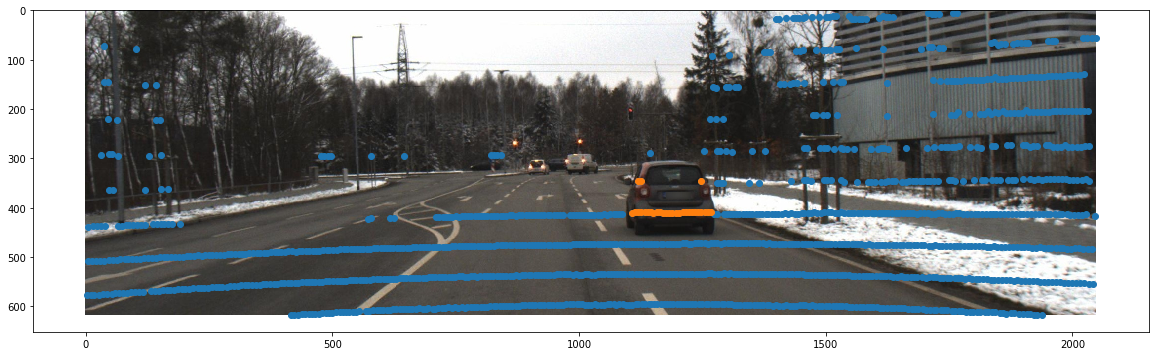

In [16]:
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(lidar_FOV[0],lidar_FOV[1])
plt.scatter(object_points_FOV[0],object_points_FOV[1])
plt.savefig("%06d_object_%d_with_points.jpg" % (idx, object_number),
            bbox_inches='tight', pad_inches=0)